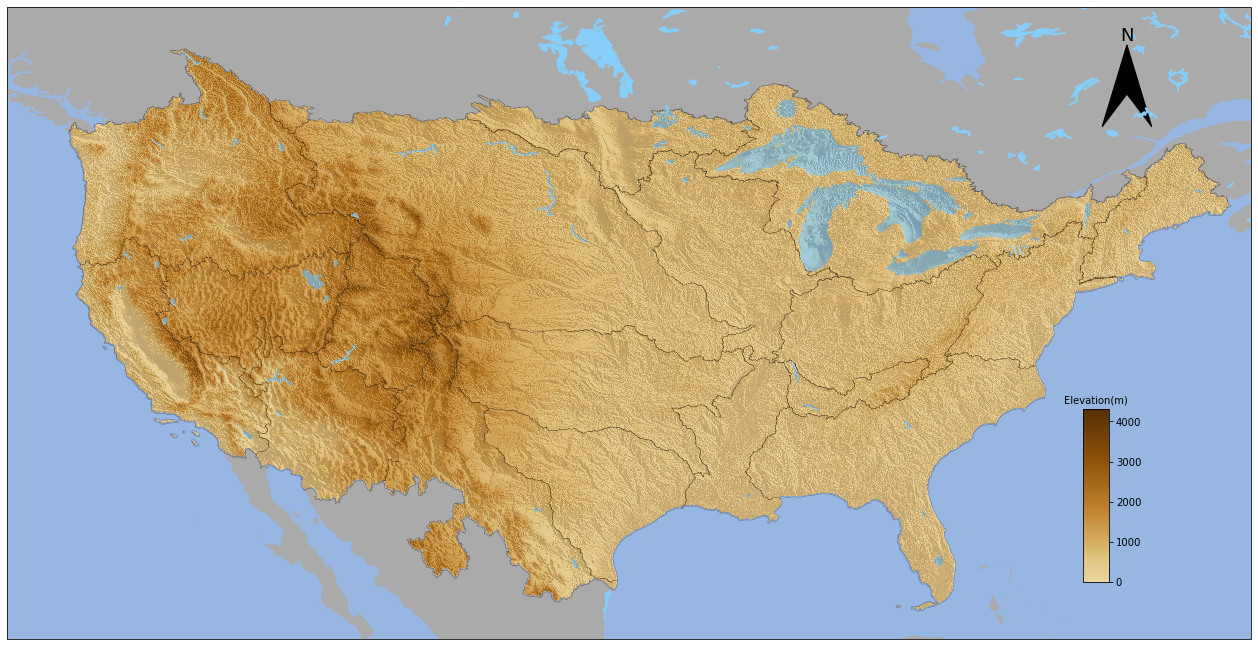

In [1]:
######dem plot
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

from cartopy.io.shapereader import Reader

import rioxarray as rxr

#
fig, ax = plt.subplots(figsize=(18, 12),
                       subplot_kw={'projection': ccrs.PlateCarree()}
                       )

# leftlon, rightlon, lowerlat, upperlat = (-128, -65, 23, 55)
leftlon, rightlon, lowerlat, upperlat = (-128, -65, 23, 55)
dem_extent=(-124.908333333333,-66.0083333333334,24.3916666666667,52.8916666666667)
ax.set_extent([leftlon, rightlon, lowerlat, upperlat], ccrs.PlateCarree())

wbd_path=r'C:\Users\dingxj\Desktop\WBD\COUNS_18.shp'
##数据加载
# dem_pre_arr = rxr.open_rasterio(r'C:\Users\dingxj\Downloads\ETOPO1_Bed_g_geotiff\COUNS.tif')
# #将numpy array 里面数据提取出来
# dem=dem_pre_arr.values[0]
# dem = dem.astype('float')
# dem[dem == -2147483648] = 'nan'
dem_pre_arr = rxr.open_rasterio(r'C:\Users\dingxj\Downloads\ETOPO1_Bed_g_geotiff\COUNS.tif').rio.write_crs(
    ccrs.PlateCarree(), inplace=True)

dem = dem_pre_arr[0]
dem = dem.where(~(dem.values == -2147483648))

#imshow plot dem
viridisBig = cm.get_cmap('BrBG_r', 512)
newcmp = ListedColormap(viridisBig(np.linspace(0.65, 1, 256)))
cbar=ax.imshow(dem.values,
              # transform=ccrs.PlateCarree(),
              # #cmap=plt.cm.Reds
                cmap=newcmp,
                extent=dem_extent,
                vmin = 0, vmax = 4302,
                transform=ccrs.PlateCarree()
              )
#测试hill shade功能
#reference:http://paisheng.me/2018/11/06/Plotting%20topography%20map%20with%20using%20Python/
def hillshade(array, azimuth, angle_altitude):
    # Source: http://geoexamples.blogspot.com.br/2014/03/shaded-relief-images-using-gdal-python.html
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi / 180.
    altituderad = angle_altitude*np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) \
     + np.cos(altituderad) * np.cos(slope) \
     * np.cos(azimuthrad - aspect)
    return 255*(shaded + 1)/2
ax.matshow(hillshade(dem, 30, 30), extent=dem_extent, cmap=newcmp, alpha=.3, zorder=10)
ax2=fig.add_axes([0.85,0.2,0.02,0.2])
ax2.set_title('Elevation(m)',fontsize=10)
fig.colorbar(cbar,cax=ax2,shrink=0.4,pad=-0.01)
#添加shp
# geodf = gpd.read_file(r'C:\Users\dingxj\Desktop\WBD\COUNS_18.shp').to_crs(ccrs.PlateCarree())
# ax = geodf.plot(ax=ax,
#                     facecolor="none",
#
#                     linewidth=0.5,
#                     alpha=0.4,
#                     k=5,
#                     )
#test cartopy shaperreader to plot geodata
#https://stackoverflow.com/questions/20990381/how-to-add-custom-shapefile-to-map-using-cartopy
shapefile=Reader(wbd_path)
ax.add_geometries(Reader(wbd_path).geometries(),
                  ccrs.PlateCarree(),
                  facecolor='none', #hatch='xxxx',
                  linewidth = 0.5,
                  alpha = 0.4,
                  # k = 5,
)

#添加指北针
def add_north(ax, labelsize=18, loc_x=0.90, loc_y=0.95, width=0.04, height=0.13, pad=0.14):
    """
    画一个比例尺带'N'文字注释
    主要参数如下
    :param ax: 要画的坐标区域 Axes实例 plt.gca()获取即可
    :param labelsize: 显示'N'文字的大小
    :param loc_x: 以文字下部为中心的占整个ax横向比例
    :param loc_y: 以文字下部为中心的占整个ax纵向比例
    :param width: 指南针占ax比例宽度
    :param height: 指南针占ax比例高度
    :param pad: 文字符号占ax比例间隙
    :return: None
    """
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    ylen = maxy - miny
    xlen = maxx - minx
    left = [minx + xlen*(loc_x - width*.5), miny + ylen*(loc_y - pad)]
    right = [minx + xlen*(loc_x + width*.5), miny + ylen*(loc_y - pad)]
    top = [minx + xlen*loc_x, miny + ylen*(loc_y - pad + height)]
    center = [minx + xlen*loc_x, left[1] + (top[1] - left[1])*.4]
    triangle = mpatches.Polygon([left, top, right, center], color='k')
    ax.text(s='N',

            x=minx + xlen*loc_x,
            y=miny + ylen*(loc_y - pad + height),
            fontsize=labelsize,
            horizontalalignment='center',
            verticalalignment='bottom')
    ax.add_patch(triangle,)
#添加cartopy要素
ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor='#AAAAAA')
ax.add_feature(cfeature.LAKES.with_scale('50m'),facecolor='lightskyblue')
# ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
#添加指北针
add_north(ax)
#调整图间距大小
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.98, hspace=0.005, wspace=0.02)
plt.show()

## http://paisheng.me/2018/11/06/Plotting%20topography%20map%20with%20using%20Python/